# Prophet 시계열 예측
---

In [74]:
import pandas as pd
import prophet
import matplotlib.pyplot as plt

## [1] 데이터 로딩
---

In [75]:
# input data 로딩
data_tomato = pd.read_csv("./data/data_tomato.csv", index_col=0)
data_rv = pd.read_csv("./data/data_rv.csv", index_col=0)
data_qva = pd.read_csv("./data/data_qva_inter.csv", index_col=0)

# 합치고 날짜 컬럼 추가
data = pd.concat([data_tomato, data_rv, data_qva], axis=1)
data.reset_index(inplace=True)
data["DATE"] = pd.to_datetime(data["DATE"])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 34 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   DATE                300 non-null    datetime64[ns]
 1   TCL_AT              300 non-null    float64       
 2   TCL_LT              300 non-null    float64       
 3   TCL_HT              300 non-null    float64       
 4   TEMP_EF_CAP         300 non-null    float64       
 5   TEMP_EF_DONGNAM     300 non-null    float64       
 6   TEMP_EF_DAEGYUNG    300 non-null    float64       
 7   TEMP_EF_CHOONG      300 non-null    float64       
 8   TEMP_EF_HONAM       300 non-null    float64       
 9   TEMP_EF_MEAN        300 non-null    float64       
 10  POWER_WATER         300 non-null    int64         
 11  POWER_FIRE          300 non-null    int64         
 12  POWER_NUCLEAR       300 non-null    int64         
 13  POWER_NAEYEON       300 non-null    int64         

## [2] prophet 모델
---

In [96]:
def prophet_model(data:pd.DataFrame, col:str, params:dict, periods:int, dtype='int'):
    """시계열 예측 결과값 반환해주는 모델
    Args:
        data: 데이터프레임
        col: 피쳐 컬럼 이름
        params: prophets 파라미터
        periods: 예측 일수
    
    Returns:
        pd.DataFrame: 예측 피쳐 데이터프레임형태 반환
    """
    data_c = data.copy()
    # rename cols
    data_c = data_c.rename(columns={col: 'y', "DATE": "ds"})
    
    # add params
    m = prophet.Prophet(**params)
    # m.add_country_holidays(country_name="KOR")
    m.add_seasonality(name="monthly", period=30.5, fourier_order=3, prior_scale=0.01, mode="multiplicative")
    
    # fit model
    m.fit(data_c)
    
    # future data
    future = m.make_future_dataframe(periods=periods, freq='MS')
    forecast = m.predict(future)
    
    # plot forecast
    fig = m.plot(forecast)
    a = prophet.plot.add_changepoints_to_plot(fig.gca(), m, forecast)
    
    # plot components
    m.plot_components(forecast)
    
    # return forecast feature
    pred = forecast["yhat"].astype(dtype)[-periods:]
    date = future.iloc[:,0][-periods:]
    result = pd.concat([date, pred], axis=1)
    
    return result


20:04:58 - cmdstanpy - INFO - Chain [1] start processing
20:04:58 - cmdstanpy - INFO - Chain [1] done processing


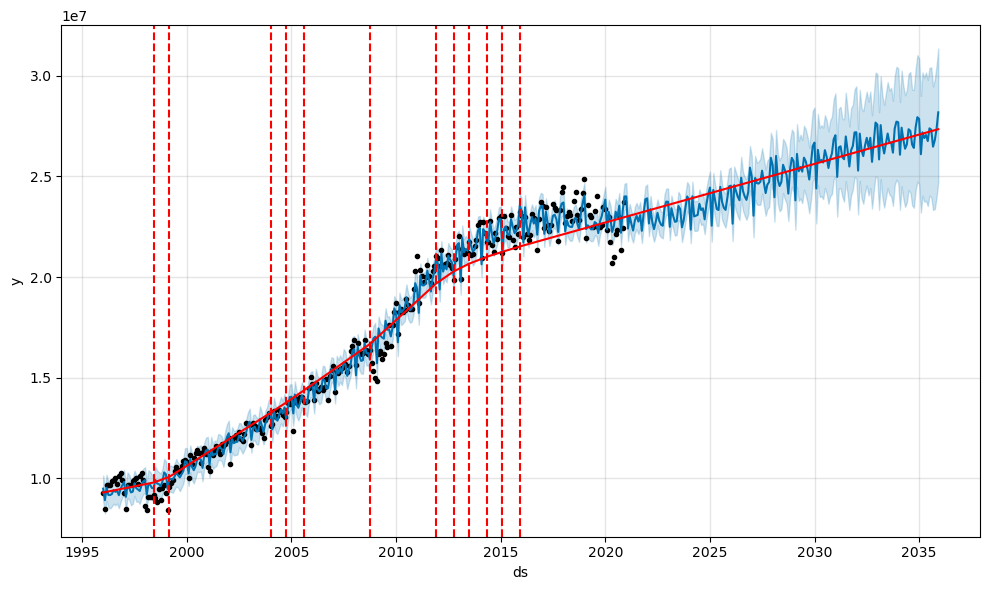

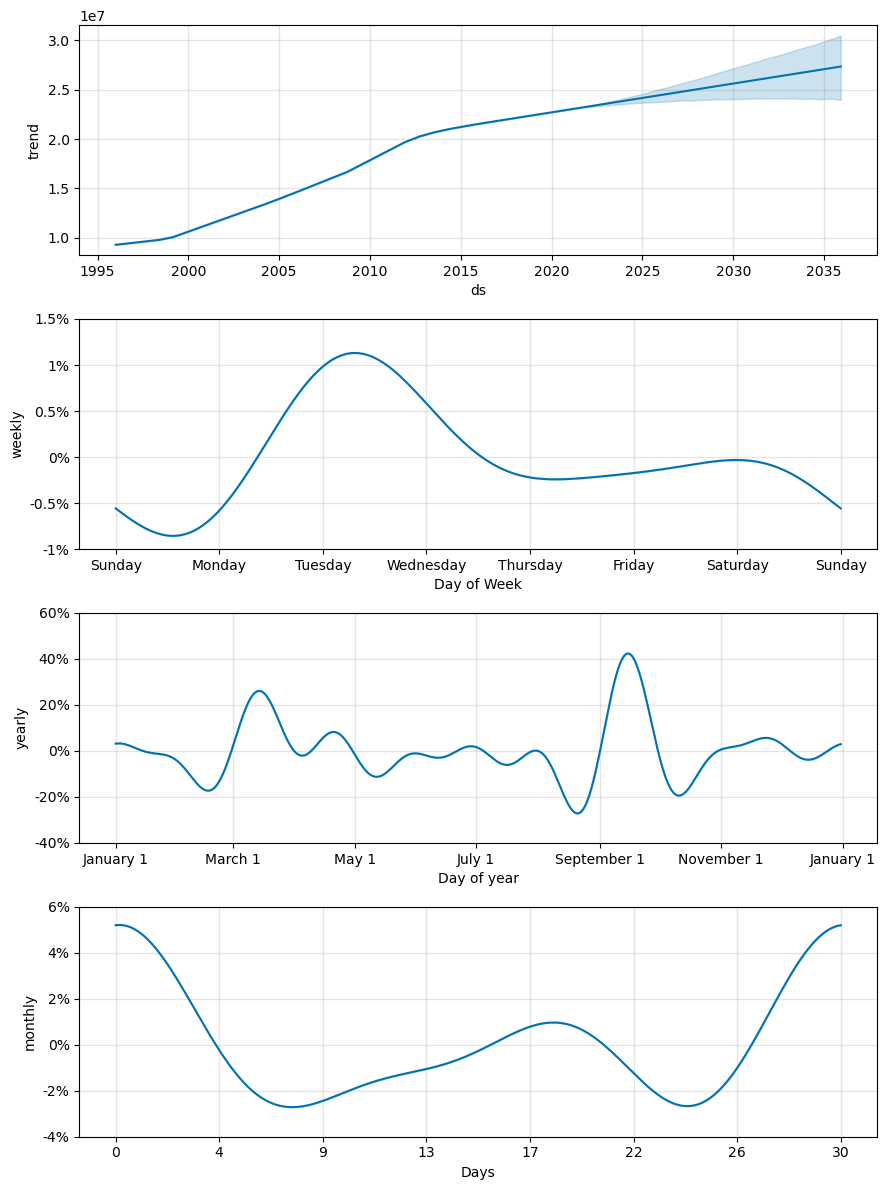

In [122]:
# default scale = 0.05
# default seasonality = 10

params = {
    "changepoint_prior_scale": 0.035,
    "changepoint_range": 0.8,
    "seasonality_prior_scale": 5,
    "weekly_seasonality": True,
    "yearly_seasonality": True,
    "daily_seasonality": False,
    "seasonality_mode": "multiplicative",
    # "holidays_prior_scale": 1,
    "interval_width": 0.8
}

pred = prophet_model(data, 'ELEC_INDSUM', params=params, periods=12*15)

In [124]:
pred.to_csv("IND_SUM_pred.csv", index=False)